In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
import importlib
import gomokutrainer
import onnx
import keras2onnx
import matplotlib.pyplot as plt
from os import path
from datetime import datetime


data_train_x_board (48468) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_train_x_turn (48468) 
 [[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
data_train_y (48468) 
 [[-0.75174477]
 [-0.7507562 ]
 [-0.75024201]
 ...
 [ 0.84530892]
 [ 0.84117927]
 [ 0.85494505]]
data_validation_x_board (2551) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_validation_x_turn (2551) 
 [[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
data_validation_y (2551) 
 [[-0.7635468 ]
 [-0.74433657]
 [-0.74030552]
 ...
 [ 0.82511058]
 [ 0.82817619]
 [ 0.83525046]]


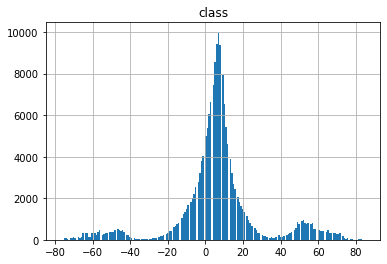

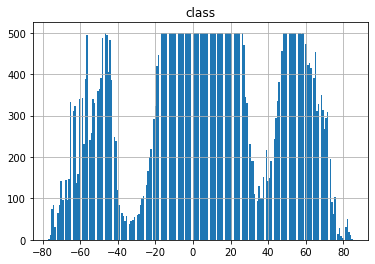

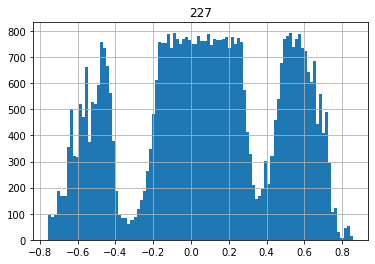

In [3]:
data_raw = pd.concat([
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_2021-05-05_09-26-20.csv", header=None, sep=';', decimal=","),
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_I30000_MEC1000_05-06_10-36-25.csv", header=None, sep=';', decimal=",")
], ignore_index = True)
input_slice = range(225)
##Reverse first player evaluations
#print("before \n", data_raw[lambda x: x[450] == 1])
data_raw = data_raw[data_raw[227] != 1].reset_index(drop = True)
data_raw.loc[lambda x: x[225] == 1,227] = data_raw.loc[lambda x: x[225] == 1,227].apply(lambda x: x*-1)
#data_raw.loc[lambda x: x[225] == 1,input_slice] = data_raw.loc[lambda x: x[225] == 1,input_slice].apply(lambda x: x*-1)
#print("after \n", data_raw[lambda x: x[450] == 1])
data_raw["class"] = data_raw[227] // 0.01

data_raw.hist(column="class", bins=200)

max_class_count = 500

data_raw = data_raw.groupby("class").apply(lambda x: x.sample(max_class_count if len(x) > max_class_count else len(x) )).reset_index(drop=True)

data_raw.hist(column="class", bins=200)

data_train = data_raw[data_raw.index % 20 != 0].reset_index(drop = True)
data_validation = data_raw[data_raw.index % 20 == 0].reset_index(drop = True)

data_train_x_board = data_train[input_slice].to_numpy()
data_train_x_turn = data_train[225].to_numpy().reshape((-1,1)) * -2 + 3
data_validation_x_board = data_validation[input_slice].to_numpy() 
data_validation_x_turn = data_validation[225].to_numpy().reshape((-1,1)) * -2 + 3

data_train_y = data_train[[227]].to_numpy()
data_validation_y = data_validation[[227]].to_numpy()

data_train.hist(column=227, bins=100)



print(f"data_train_x_board ({len(data_train_x_board)}) \n", data_train_x_board)
print(f"data_train_x_turn ({len(data_train_x_turn)}) \n", data_train_x_turn)
print(f"data_train_y ({len(data_train_y)}) \n", data_train_y)
print(f"data_validation_x_board ({len(data_validation_x_board)}) \n", data_validation_x_board)
print(f"data_validation_x_turn ({len(data_validation_x_turn)}) \n", data_validation_x_turn)
print(f"data_validation_y ({len(data_validation_y)}) \n", data_validation_y)

#print(data_train_x[100])
#print(data_train_y[100])

In [4]:
#importlib.reload(gomokutrainer)
#from gomokutrainer import create_model
#model = create_model()
input_shape = (15,15,1)
input_len = input_shape[0] * input_shape[1] * input_shape[2]
"""
model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(128, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(128,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )
  """
"""
model = keras.Sequential(
  [
    keras.Input(shape=input_len, name="input"),

    layers.Reshape(input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Flatten(),

    layers.Dropout(0.5),

    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(1, activation='tanh', name="output")
  ]
)
"""
"""
model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )"""
inputA = keras.Input(shape=input_len, name="input_board")
inputB = keras.Input(shape=1, name="input_turn")
a = layers.Reshape(input_shape)(inputA)

a = layers.Conv2D(32, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Conv2D(64, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Conv2D(64, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Flatten()(a)

a =  layers.Dropout(0.5)(a)

a = layers.Dense(64, kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

#b = layers.Dense(2, kernel_initializer=keras.initializers.HeNormal())(inputB)
#b = layers.LeakyReLU(alpha=0.2)(b)

#a = layers.Concatenate()([a, b])
a = layers.Concatenate()([a, inputB])

a = layers.Dense(32, kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Dense(1, activation='tanh', name="output")(a)

model = keras.Model(inputs=[inputA,inputB], outputs=a)

model.compile(tf.optimizers.RMSprop(), loss='mse')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_board (InputLayer)        [(None, 225)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 15, 15, 1)    0           input_board[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   160         reshape[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 32)   0           conv2d[0][0]                     
_______________________________________________________________________________________

In [5]:
history = model.fit([data_train_x_board,data_train_x_turn], data_train_y, epochs=30, 
    validation_data=([data_validation_x_board,data_validation_x_turn], data_validation_y))

#predictions = model.predict(data_validation_x)

Epoch 1/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0445 - val_loss: 0.0236
Epoch 2/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0219 - val_loss: 0.0160
Epoch 3/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0170 - val_loss: 0.0129
Epoch 4/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0143 - val_loss: 0.0108
Epoch 5/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 6/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0116 - val_loss: 0.0083
Epoch 7/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0107 - val_loss: 0.0084
Epoch 8/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 9/30
1515/1515 [==============================] - 29s 19ms/step - loss: 0.0095 - val_loss: 0.0071
Epoch 10/30
1515/1515 [==============================] - 29s 19m

minimal validation loss = 0.004332096315920353


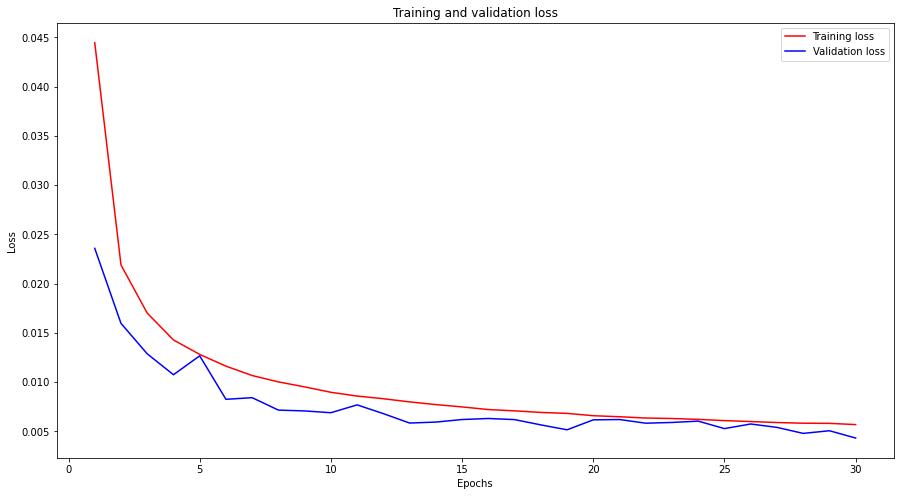

In [6]:

history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'minimal validation loss = {min(val_loss)}' )

In [7]:
output_path = path.join("C:\\","Projects","TrainDatasetGenerator","TrainedModels", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
model.save(path.join(output_path,"keras-model"))
onnx_model = keras2onnx.convert_keras(model, "model.onnx")
onnx.save_model(onnx_model, path.join(output_path, "model.onnx"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Projects\TrainDatasetGenerator\TrainedModels\2021-05-18_17-08-34\keras-model\assets
tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 36 -> 20
The maximum opset needed by this model is only 11.


In [8]:

def draw_board(arr): 
    BOARD_SIZE = 15
    s = ""
    for row in range(BOARD_SIZE):
        if(BOARD_SIZE - row < 10):
            s += ' '
        s += str(BOARD_SIZE - row)
        for column in range(BOARD_SIZE):
            cell = arr[row * BOARD_SIZE + column]
            if(cell == 0):
                s += ' '
            elif(cell == 1):
                s += 'x'
            elif(cell == -1):
                s += 'o'
            else:
                raise Exception("Error")
            
            
        
        s += '\n'
    
    s += '  '
    for column in range(BOARD_SIZE):
        s += chr(65 + column)
    return s
        

In [37]:
s = slice(38110,38120)
samples_board = data_train_x_board[s]
samples_turn = data_train_x_turn[s]
samples_eval = data_train_y[s]
predictions = model.predict([samples_board, samples_turn])
for i in range(len(predictions)):
    print(draw_board(samples_board[i]))
    print("turn:", samples_turn[i])
    print("prediction:", predictions[i])
    print("expected:", samples_eval[i])
    print("\n")

15               
14      x        
13     xo    x   
12      o   o    
11    x ooxo     
10     oxxoxo    
 9      ooxox o  
 8      xoxxxxo  
 7       xo x    
 6         x oo  
 5        x      
 4       o       
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
prediction: [0.49423885]
expected: [0.48727615]


15               
14               
13     x         
12     o  x      
11    ooox       
10     ox        
 9    oxxo       
 8     o xo      
 7        xx     
 6         x     
 5          o    
 4               
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
prediction: [0.53271127]
expected: [0.48425787]


15               
14               
13               
12           o   
11      o   x    
10   oo  x xx    
 9     xoox      
 8     oxxoxx    
 7      o   x    
 6           o   
 5            o  
 4               
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
predic